# Action Part 2: let's make a Chatbot

In [22]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [2]:
# Load environment variables in a file called .env

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [3]:
# Initialize

openai = OpenAI()
MODEL = 'gpt-4o-mini'

In [4]:
system_message = "You are a helpful assistant"

## Reminder of the structure of prompt messages to OpenAI:

```
[
    {"role": "system", "content": "system message here"},
    {"role": "user", "content": "first user prompt here"},
    {"role": "assistant", "content": "the assistant's response"},
    {"role": "user", "content": "the new user prompt"},
]
```

We will write a function `chat(message, history)` where:
**message** is the prompt to use
**history** is a list of pairs of user message with assistant's reply

```
[
    ["user said this", "assistant replied"],
    ["then user said this", "and assistant replied again],
    ...
]
```
We will convert this history into the prompt style for OpenAI, then call OpenAI. 


In [7]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}]
    for user_message, assistant_message in history:
        messages.append({"role": "user", "content": user_message})
        messages.append({"role": "assistant", "content": assistant_message})
    messages.append({"role": "user", "content": message})

    print("History is:")
    print(history)
    print("And messages is:")
    print(messages)

    stream = openai.chat.completions.create(model=MODEL, messages=messages, stream=True)

    response = ""
    for chunk in stream:
        response += chunk.choices[0].delta.content or ''
        yield response

## And then enter Gradio's magic!

In [8]:
gr.ChatInterface(fn=chat).launch(inbrowser=True)

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [9]:
system_message = "You are a helpful assistant in a clothes store. You should try to gently encourage \
the customer to try items that are on sale. Hats are 60% off, and most other items are 50% off. \
For example, if the customer says 'I'm looking to buy a hat', \
you could reply something like, 'Wonderful - we have lots of hats - including several that are part of our sales evemt.'\
Encourage the customer to buy hats if they are unsure what to get."

In [10]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}]
    for user_message, assistant_message in history:
        messages.append({"role": "user", "content": user_message})
        messages.append({"role": "assistant", "content": assistant_message})
    messages.append({"role": "user", "content": message})

    stream = openai.chat.completions.create(model=MODEL, messages=messages, stream=True)

    response = ""
    for chunk in stream:
        response += chunk.choices[0].delta.content or ''
        yield response

In [11]:
gr.ChatInterface(fn=chat).launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


In [ ]:
system_message += "\nIf the customer asks for shoes, you should respond that shoes are not on sale today, \
but remind the customer to look at hats!"

In [ ]:
gr.ChatInterface(fn=chat).launch()

In [ ]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}]
    for user_message, assistant_message in history:
        messages.append({"role": "user", "content": user_message})
        messages.append({"role": "assistant", "content": assistant_message})

    if 'belt' in message:
        messages.append({"role": "system", "content": "For added context, the store does not sell belts, \
but be sure to point out other items on sale"})
    
    messages.append({"role": "user", "content": message})

    stream = openai.chat.completions.create(model=MODEL, messages=messages, stream=True)

    response = ""
    for chunk in stream:
        response += chunk.choices[0].delta.content or ''
        yield response

In [ ]:
gr.ChatInterface(fn=chat).launch()

# Project - Airline AI Assistant

We'll now bring together what we've learned to make an AI Customer Support assistant for an Airline

In [13]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [14]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}]
    for human, assistant in history:
        messages.append({"role": "user", "content": human})
        messages.append({"role": "assistant", "content": assistant})
    messages.append({"role": "user", "content": message})
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat).launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


## Tools

Tools are an incredibly powerful feature provided by the frontier LLMs.

With tools, you can write a function, and have the LLM call that function as part of its response.

Sounds almost spooky.. we're giving it the power to run code on our machine?

Well, kinda.

In [15]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [16]:
get_ticket_price("London")

Tool get_ticket_price called for London


'$799'

In [17]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [18]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}]

## Getting OpenAI to use our Tool

There's some fiddly stuff to allow OpenAI "to call our tool"

What we actually do is give the LLM the opportunity to inform us that it wants us to run the tool.

Here's how the new chat function looks:

In [19]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}]
    for human, assistant in history:
        messages.append({"role": "user", "content": human})
        messages.append({"role": "assistant", "content": assistant})
    messages.append({"role": "user", "content": message})
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [23]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": message.tool_calls[0].id
    }
    return response, city

In [24]:
gr.ChatInterface(fn=chat).launch(inbrowser=True)

Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for London


# Let's go multi-modal!!

We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images

Let's put this in a function called artist.

### Price alert: each time I generate an image it costs about 4c - don't go crazy with images!

In [25]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [26]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

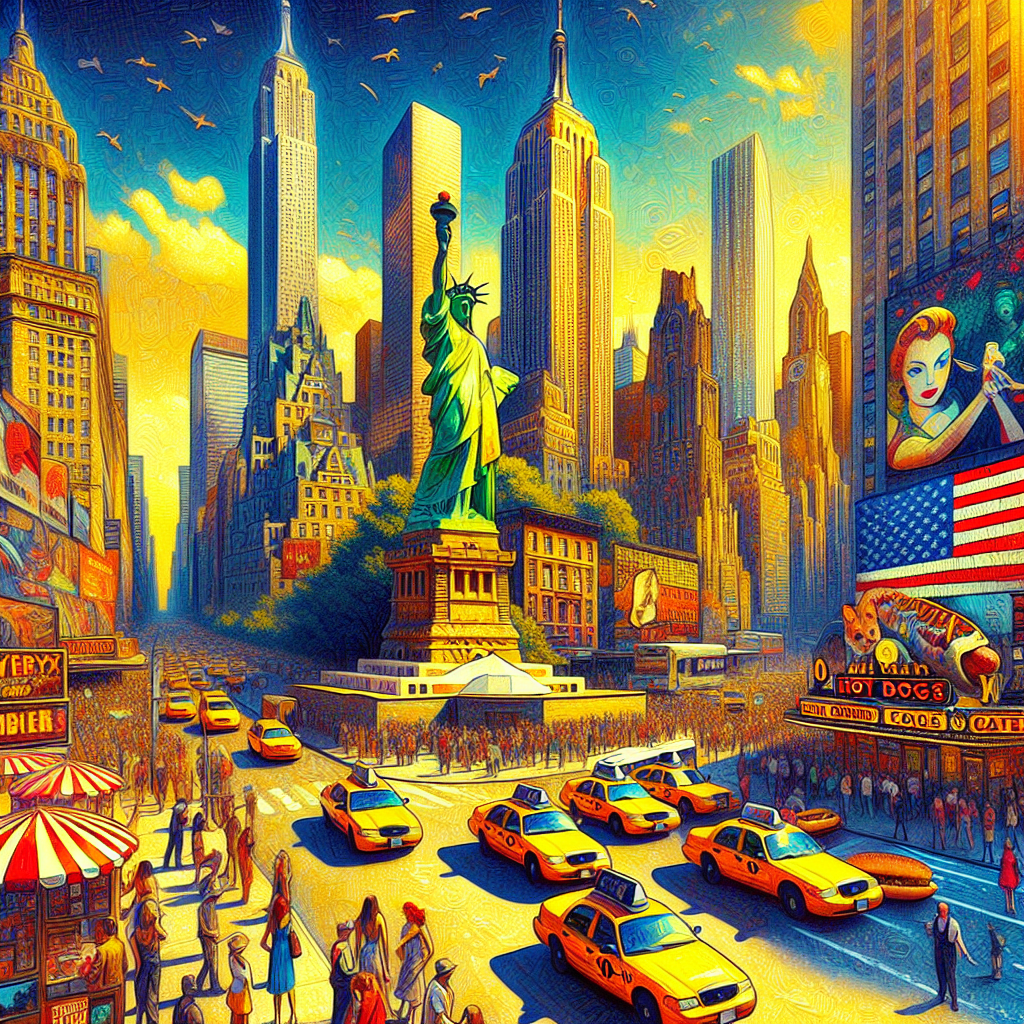

In [27]:
image = artist("New York City")
display(image)

# Bringing it together into a mini-agent framework

In [30]:
def chat(message, history):
    image = None
    conversation = [{"role": "system", "content": system_message}]
    for human, assistant in history:
        conversation.append({"role": "user", "content": human})
        conversation.append({"role": "assistant", "content": assistant})
    conversation.append({"role": "user", "content": message})
    response = openai.chat.completions.create(model=MODEL, messages=conversation, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = tool_call = response.choices[0].message
        response, city = handle_tool_call(message)
        conversation.append(message)
        conversation.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=conversation)

    reply = response.choices[0].message.content
    return reply, image

In [31]:
# More involved Gradio code as we're not using the preset Chat interface

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500)
        image_output = gr.Image(height=500)
    with gr.Row():
        msg = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def user(user_message, history):
        return "", history + [[user_message, None]]

    def bot(history):
        user_message = history[-1][0]
        bot_message, image = chat(user_message, history[:-1])
        history[-1][1] = bot_message
        return history, image

    msg.submit(user, inputs=[msg, chatbot], outputs=[msg, chatbot], queue=False).then(
        bot, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for Paris
